In [2]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

gpt2, gpt2_tokenizer, gpt2_data, gpt2_ratio = load_stuff("gpt2")
neo, neo_tokenizer, neo_data, neo_ratio = load_stuff("EleutherAI/gpt-neo-125M")
pythia, pythia_tokenizer, pythia_data, pythia_ratio = load_stuff("EleutherAI/pythia-125m")

Using custom data configuration default-17b5822e070b1eaf
Found cached dataset json (/mnt/ssd-1/nora/huggingface/datasets/json/default-17b5822e070b1eaf/0.0.0)


Using custom data configuration default-17b5822e070b1eaf


In [15]:
from dataclasses import dataclass
from itertools import islice
from torch.utils.data import DataLoader
from typing import Literal
from transformers import PreTrainedModel
from tqdm.auto import tqdm
from white_box.causal import ablate_layer
from white_box.stats import kl_divergence
from white_box.utils import send_to_device
import torch as th


def entropy(logits: th.Tensor):
    log_probs = logits.log_softmax(dim=-1)
    return -th.sum(log_probs.exp() * log_probs, dim=-1)


@dataclass
class LayerAblationResult:
    baseline_entropies: th.Tensor
    baseline_losses: th.Tensor

    entropies: th.Tensor
    fwd_kls: th.Tensor
    losses: th.Tensor
    rev_kls: th.Tensor


@th.autocast("cuda", enabled=th.cuda.is_available())
@th.no_grad()
def run_layer_ablation(
    model: PreTrainedModel,
    data,
    ratio,
    limit: int = 50,
    method: Literal["resample", "mean", "zero"] = "mean"
):
    losses = []
    model.eval()

    device = model.device
    N = min(len(data), limit)
    L = model.config.num_hidden_layers
    result = LayerAblationResult(
        baseline_entropies=th.zeros(N, dtype=th.float32, device=device),
        baseline_losses=th.zeros(N, dtype=th.float32, device=device),
        entropies=th.zeros(N, L, dtype=th.float32, device=device),
        fwd_kls=th.zeros(N, L, dtype=th.float32, device=device),
        losses=th.zeros(N, L, dtype=th.float32, device=device),
        rev_kls=th.zeros(N, L, dtype=th.float32, device=device),
    )

    dl = DataLoader(data, batch_size=12)
    pbar = tqdm(islice(dl, limit), total=limit)
    for batch in pbar:
        batch = send_to_device(batch, device)
        i = pbar.n

        baseline_output = model(**batch, labels=batch['input_ids'])
        result.baseline_entropies[i] = entropy(baseline_output.logits).mean()
        result.baseline_losses[i] = baseline_output.loss * ratio

        for j in range(L):
            with ablate_layer(model, j, method=method):
                outputs = model(**batch, labels=batch['input_ids'])
                result.entropies[i, j] = entropy(outputs.logits).mean()
                result.fwd_kls[i, j] = kl_divergence(baseline_output.logits, outputs.logits).mean()
                result.losses[i, j] = outputs.loss * ratio
                result.rev_kls[i, j] = kl_divergence(outputs.logits, baseline_output.logits).mean()

    return result

In [6]:
import matplotlib.pyplot as plt
import plotly.express as px


def plot_losses(losses, name, baseline = None, tick_step = 1):
    # Add confidence interval bands based on standard error
    mean = losses.mean(dim=0)
    stderr = losses.std(dim=0) / losses.shape[0] ** 0.5
    plt.fill_between(
        range(len(mean)),
        mean - stderr * 1.96,
        mean + stderr * 1.96,
        alpha=0.2
    )
    plt.plot(mean, label=name, marker="o")

    if baseline is not None:
        plt.hlines(
            baseline, 0, len(mean) - 1,
            linestyles="dashed", label=f"Baseline"
        )
        
    # plt.ylim(0, mean.max() * 1.1)
    plt.xticks(range(0, len(mean), tick_step))
    plt.xlabel("Layer ablated")
    plt.ylabel("bits per byte")

## GPT-2

In [7]:
# gpt2_resample = run_layer_ablation(
#     gpt2, gpt2_data, gpt2_ratio, method="resample"
# )
gpt2_mean = run_layer_ablation(
    gpt2, gpt2_data, gpt2_ratio, method="mean"
)
gpt2_zero = run_layer_ablation(
    gpt2, gpt2_data, gpt2_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## GPT Neo

In [16]:
neo_resample = run_layer_ablation(
    neo, neo_data, neo_ratio, method="resample"
)
neo_mean = run_layer_ablation(
    neo, neo_data, neo_ratio, method="mean"
)
neo_zero = run_layer_ablation(
    neo, neo_data, neo_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

## Pythia

In [4]:
pythia_resample = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="resample"
)
pythia_mean = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="mean"
)
pythia_zero = run_layer_ablation(
    pythia, pythia_data, pythia_ratio, method="zero"
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Comparing layer ablation methods for GPT-2 (125M)')

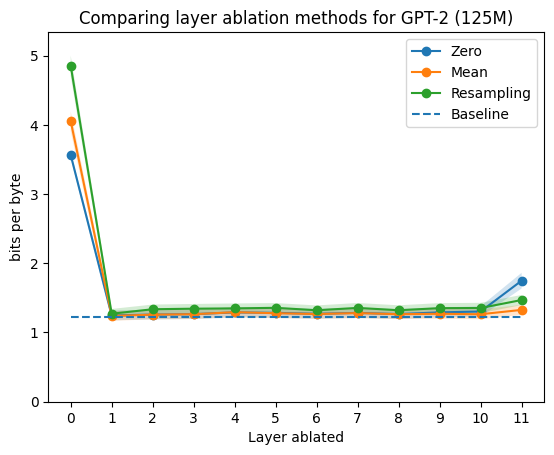

In [9]:
plot_losses(gpt2_zero.losses.cpu(), "Zero")
plot_losses(gpt2_mean.losses.cpu(), "Mean")
plot_losses(gpt2_resample.losses.cpu(), "Resampling", gpt2_resample.baseline_losses.mean().item())
plt.legend()
plt.title("Comparing layer ablation methods for GPT-2 (125M)")

Text(0, 0.5, 'Entropy (bits per byte)')

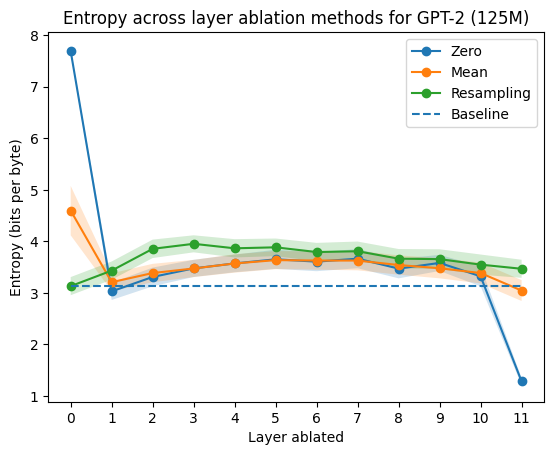

In [18]:
plot_losses(gpt2_zero.entropies.cpu(), "Zero")
plot_losses(gpt2_mean.entropies.cpu(), "Mean")
plot_losses(gpt2_resample.entropies.cpu(), "Resampling", gpt2_resample.baseline_entropies.mean().item())
plt.legend()
plt.title("Entropy across layer ablation methods for GPT-2 (125M)")
plt.ylabel("Entropy (bits per byte)")

Text(0, 0.5, 'Forward KL (bits per byte)')

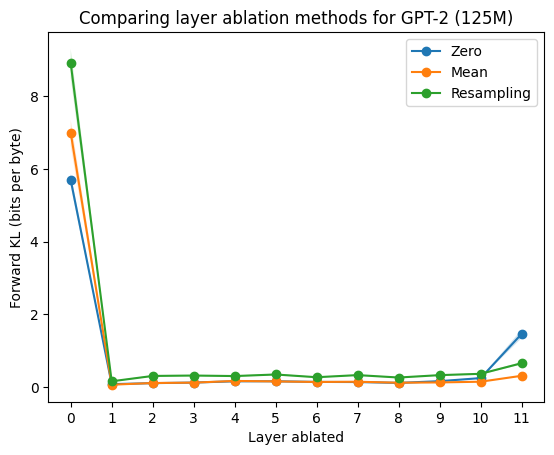

In [16]:
plot_losses(gpt2_zero.fwd_kls.cpu(), "Zero")
plot_losses(gpt2_mean.fwd_kls.cpu(), "Mean")
plot_losses(gpt2_resample.fwd_kls.cpu(), "Resampling")
plt.legend()
plt.title("Comparing layer ablation methods for GPT-2 (125M)")
plt.ylabel("Forward KL (bits per byte)")

Text(0.5, 1.0, 'Comparing layer ablation methods for Pythia (125M)')

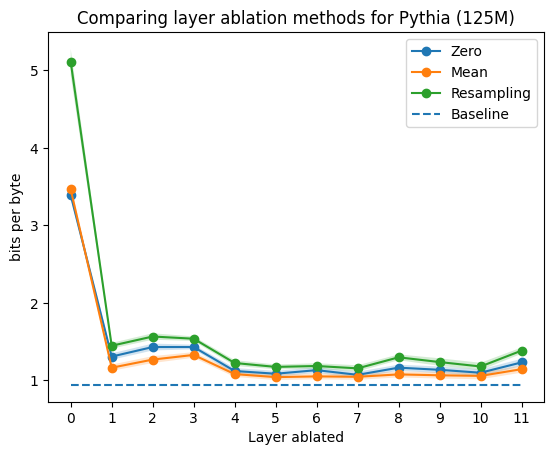

In [8]:
plot_losses(pythia_zero.losses.cpu(), "Zero")
plot_losses(pythia_mean.losses.cpu(), "Mean")
plot_losses(pythia_resample.losses.cpu(), "Resampling", pythia_resample.baseline_losses.mean().item())
plt.legend()
plt.title("Comparing layer ablation methods for Pythia (125M)")

Text(0, 0.5, 'Entropy (bits per byte)')

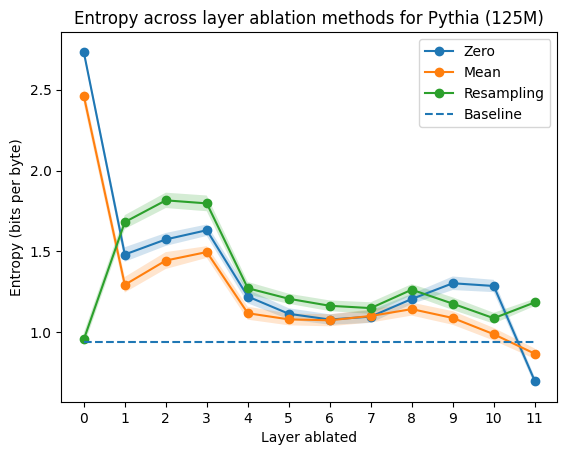

In [11]:
plot_losses(pythia_zero.entropies.cpu() * pythia_ratio, "Zero")
plot_losses(pythia_mean.entropies.cpu() * pythia_ratio, "Mean")
plot_losses(
    pythia_resample.entropies.cpu() * pythia_ratio, "Resampling",
    pythia_resample.baseline_entropies.mean().item() * pythia_ratio
)
plt.legend()
plt.title("Entropy across layer ablation methods for Pythia (125M)")
plt.ylabel("Entropy (bits per byte)")

Text(0, 0.5, 'Entropy (bits per byte)')

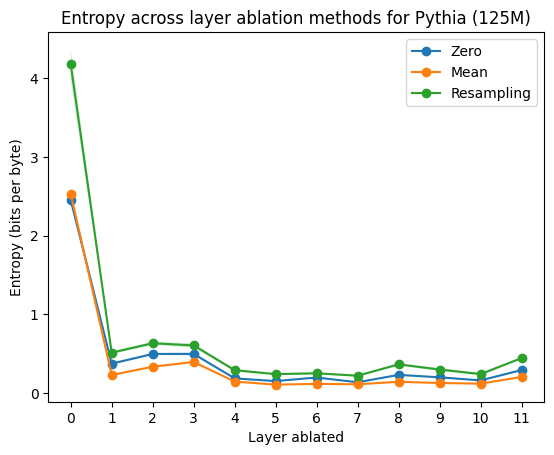

In [12]:
plot_losses(pythia_zero.fwd_kls.cpu() * pythia_ratio, "Zero")
plot_losses(pythia_mean.fwd_kls.cpu() * pythia_ratio, "Mean")
plot_losses(
    pythia_resample.fwd_kls.cpu() * pythia_ratio, "Resampling",
)
plt.legend()
plt.title("Entropy across layer ablation methods for Pythia (125M)")
plt.ylabel("Entropy (bits per byte)")

Text(0, 0.5, 'Entropy (bits per byte)')

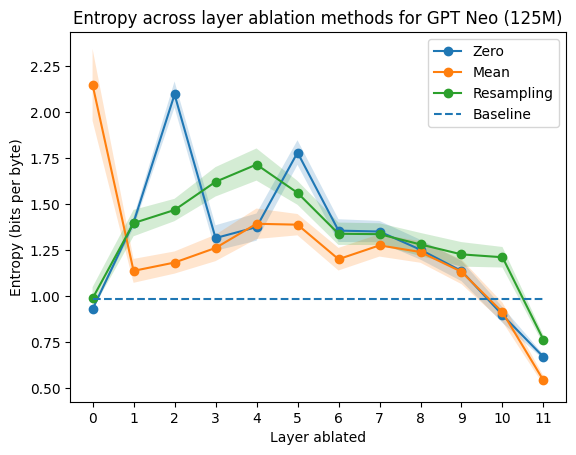

In [19]:
plot_losses(neo_zero.entropies.cpu() * neo_ratio, "Zero")
plot_losses(neo_mean.entropies.cpu() * neo_ratio, "Mean")
plot_losses(neo_resample.entropies.cpu() * neo_ratio, "Resampling", neo_resample.baseline_entropies.mean().item() * neo_ratio)
plt.legend()
plt.title("Entropy across layer ablation methods for GPT Neo (125M)")
plt.ylabel("Entropy (bits per byte)")

Text(0, 0.5, 'KL (bits per byte)')

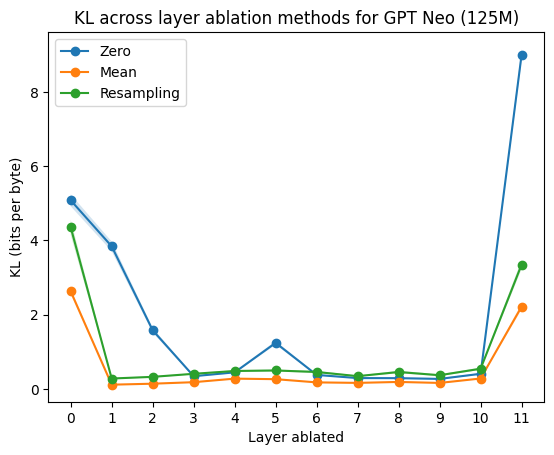

In [23]:
plot_losses(neo_zero.fwd_kls.cpu() * neo_ratio, "Zero")
plot_losses(neo_mean.fwd_kls.cpu() * neo_ratio, "Mean")
plot_losses(neo_resample.fwd_kls.cpu() * neo_ratio, "Resampling")
plt.legend()
plt.title("KL across layer ablation methods for GPT Neo (125M)")
plt.ylabel("KL (bits per byte)")

Text(0, 0.5, 'Loss (bits per byte)')

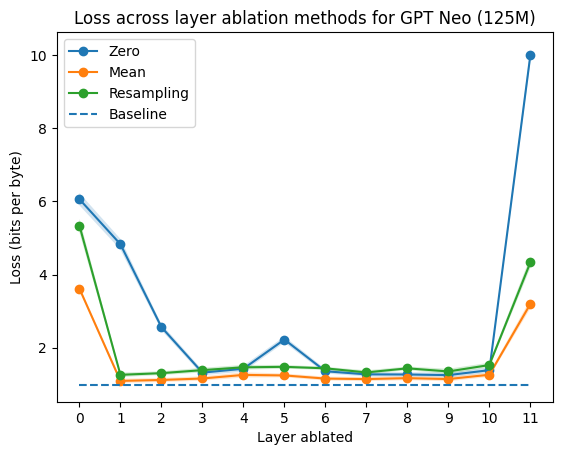

In [25]:
plot_losses(neo_zero.losses.cpu(), "Zero")
plot_losses(neo_mean.losses.cpu(), "Mean")
plot_losses(neo_resample.losses.cpu(), "Resampling", neo_resample.baseline_losses.mean().cpu())
plt.legend()
plt.title("Loss across layer ablation methods for GPT Neo (125M)")
plt.ylabel("Loss (bits per byte)")